In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('D:/Penn/Career/Citadel/2021datathon')
match = pd.read_csv('match_discrete_htwt_drop30.csv')
match['date']  = pd.to_datetime(match['date'])
df_clus = pd.read_csv('team_att_all_w_cluster.csv')
df_clus['date']  = pd.to_datetime(df_clus['date'])

In [3]:
match.shape

(17581, 201)

In [4]:
Nc = df_clus['cluster'].max() + 1
Nc

10

In [5]:
def get_meta(team_id, date):
    df = df_clus[df_clus['team_id'] == team_id]

    # return -1 if there is no record of the team's meta
    if df.shape[0] == 0:
        return -1

    clus = df.iloc[0, :]['cluster']
    for i in range(1, df.shape[0]):
        if df.iloc[i, :]['date'] < date:
            clus = df.iloc[i, :]['cluster']
        else:
            break
    
    return clus

In [6]:
# The following matrices register information only on the upper half - i.e. i >= j
goal_mat = np.zeros((Nc, Nc)) # goal_mat[i][j] is the net # of goals meta i scored against meta j. Could be positive or negative
match_mat = np.zeros((Nc, Nc)) # match_mat[i][j] is the total # of matches meta i played against meta j

for row in range(match.shape[0]):
    h_meta = get_meta(match['home_team_id'].loc[row], match['date'].loc[row])
    if h_meta < 0:
        continue
    a_meta = get_meta(match['away_team_id'].loc[row], match['date'].loc[row])
    if a_meta < 0:
        continue

    if h_meta < a_meta:
        match_mat[h_meta, a_meta] += 1
        goal_mat[h_meta, a_meta] += match['home_team_goal'].loc[row] - match['away_team_goal'].loc[row]
    else:
        match_mat[a_meta, h_meta] += 1
        goal_mat[a_meta, h_meta] += match['away_team_goal'].loc[row] - match['home_team_goal'].loc[row]

In [7]:
print(match_mat)
print(goal_mat)

[[586. 684. 522. 275. 555.  38. 466. 820.  53. 121.]
 [  0. 382. 197.  78. 194.  13. 336. 610.  57. 230.]
 [  0.   0. 578. 682. 622.  30. 480. 701. 176.  21.]
 [  0.   0.   0. 200. 314.  49. 306. 472.  13.   3.]
 [  0.   0.   0.   0. 396. 174. 601. 593. 212.  30.]
 [  0.   0.   0.   0.   0. 390.  25.  29.  42.  22.]
 [  0.   0.   0.   0.   0.   0. 323. 685.  69. 268.]
 [  0.   0.   0.   0.   0.   0.   0. 607.  32.  96.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 361. 108.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 801.]]
[[-158.  113. -197. -326. -760.   -6.  -64. -265.  -47.   65.]
 [   0. -147. -116.  -88. -228.  -23. -180. -502.  -28.  131.]
 [   0.    0. -181. -617. -589.    2.  142.   21.   39.   28.]
 [   0.    0.    0.  -96.  -14.   35.  348.  504.   22.    6.]
 [   0.    0.    0.    0. -186.  134.  549.  700.  160.   50.]
 [   0.    0.    0.    0.    0. -221.   -6.  -14.    6.   16.]
 [   0.    0.    0.    0.    0.    0. -132.  -94.    6.  394.]
 [   0.    0.    0.    0.   

In [8]:
meta_mat = np.divide(goal_mat, match_mat, out = np.zeros_like(match_mat), where = match_mat != 0)
np.set_printoptions(precision = 3)
print(meta_mat)

[[-0.27   0.165 -0.377 -1.185 -1.369 -0.158 -0.137 -0.323 -0.887  0.537]
 [ 0.    -0.385 -0.589 -1.128 -1.175 -1.769 -0.536 -0.823 -0.491  0.57 ]
 [ 0.     0.    -0.313 -0.905 -0.947  0.067  0.296  0.03   0.222  1.333]
 [ 0.     0.     0.    -0.48  -0.045  0.714  1.137  1.068  1.692  2.   ]
 [ 0.     0.     0.     0.    -0.47   0.77   0.913  1.18   0.755  1.667]
 [ 0.     0.     0.     0.     0.    -0.567 -0.24  -0.483  0.143  0.727]
 [ 0.     0.     0.     0.     0.     0.    -0.409 -0.137  0.087  1.47 ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.357  0.625  0.969]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.407  0.037]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.23 ]]


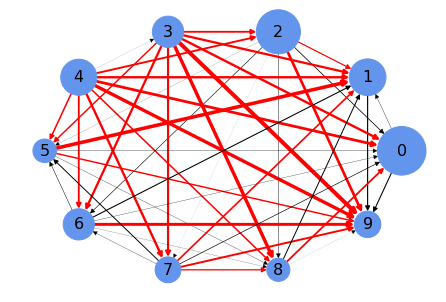

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

wt_fac = 2
nd_base = 300
nd_fac = 0.5

G = nx.DiGraph()
wt_thr = np.percentile(abs(meta_mat), 75)

for i in range(0, Nc):
    for j in range(i, Nc):
        color = 'red' if abs(meta_mat[i, j]) > wt_thr else 'black'
        if meta_mat[i, j] > 0:
            G.add_edge(i, j, weight = meta_mat[i, j] * wt_fac, color = color)
        else:
            G.add_edge(j, i, weight = -meta_mat[i, j] * wt_fac, color = color)

pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

nx.draw(G, pos, width = weights, with_labels = True, \
    node_size = np.array([sum(match_mat[i]) for i in range(Nc)]) * nd_fac + nd_base, \
    node_color='cornflowerblue', font_size = 16, edge_color = colors)
plt.show()